# Poisonous Mushrooms: Pré-Processamento

**Universidade Federal de Ouro Preto**

**PCC142 - Mineração de Dados - 2025/1**

**Prof. Anderson Almeida Ferreira**

**Victor G. Lima**

**Conteúdo**    

  - Ambiente    
    - Pacotes e importações    
    - Funções auxiliares    
  - Download do dataset    
    - Kaggle Mushroom    
    - UCI Mushroom    
    - Secondary Mushroom    
  - *Overview* do dataset    
    - Target    
    - Features    
  - Pré-processamento    
    - Limpeza de dados    
    - Preenchimento de valores ausentes    
    - Transformação dos dados    
    - Detecção de *outliers*    
    - Correlação de atributos    
  - Pipeline    
    - Pré-processamento do dataset de treino    
    - Pré-processamento do dataset de teste    
  - Referências    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=false
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

A identificação de cogumelos como comestíveis ou venenosos é um importante assunto na micologia, área da biologia que estuda os fungos. Dada a semelhança morfológica entre espécies inofensivas e letais, a identificação desses seres como comestíveis ou não se torna um desafio. 

A partir de um dataset contendo informações sobre as características físicas de diversos cogumelos, o objetivo deste trabalho é criar um modelo de classificação binária capaz de predizer com precisão se um cogumelo é comestível ou venenoso.

## Ambiente

### Pacotes e importações

In [7]:
from IPython.display import clear_output

%pip install numpy pandas matplotlib seaborn scikit-learn scipy tqdm

import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import zscore
from tqdm import tqdm

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
sns.set_theme()

clear_output()

### Funções auxiliares

In [2]:
def plot_features(features, df, max_categories=15):
    if isinstance(features, str):
        features = [features]

    numerical_features = []
    categorical_features = []

    for feature in features:
        if feature in df.columns:
            dtype = df[feature].dropna().dtype
            if pd.api.types.is_numeric_dtype(dtype):
                numerical_features.append(feature)
            else:
                categorical_features.append(feature)

    total_numerical = len(numerical_features)
    total_categorical = len(categorical_features)
    total_rows = (1 if total_numerical > 0 else 0) + (1 if total_categorical > 0 else 0)
    max_cols = max(total_numerical, total_categorical, 1)

    fig, axes = plt.subplots(
        total_rows, max_cols, figsize=(max_cols * 4, total_rows * 3)
    )
    if total_rows == 1 and max_cols == 1:
        axes = np.array([[axes]])
    elif total_rows == 1:
        axes = np.array([axes])
    elif max_cols == 1:
        axes = np.array([[ax] for ax in axes])
    else:
        axes = axes.reshape((total_rows, max_cols))

    if total_numerical > 0:
        global_x_min = float("inf")
        global_x_max = -float("inf")
        global_y_max = 0
        for feature in numerical_features:
            data = df[feature].dropna()
            hist, bins = np.histogram(data, bins=50)
            global_x_min = min(global_x_min, data.min())
            global_x_max = max(global_x_max, data.max())
            global_y_max = max(global_y_max, hist.max())

        for i, feature in enumerate(numerical_features):
            ax = axes[0, i]
            data = df[feature].dropna()
            ax.hist(data, bins=50, alpha=1.0)
            ax.set_title(f"{feature}")
            ax.set_xlim(global_x_min, global_x_max)
            ax.set_ylim(0, global_y_max * 1.05)
            if i != 0:
                ax.set_yticklabels([])
                ax.set_ylabel("")
            ax.text(
                0.6,
                0.85,
                (
                    f"Min: {data.min():.2f}\n"
                    f"Max: {data.max():.2f}\n"
                    f"Mean: {data.mean():.2f}\n"
                    f"Median: {data.median():.2f}\n\n"
                    f"Missing: {df[feature].isna().sum()}"
                ),
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                horizontalalignment="left",
                bbox=dict(
                    boxstyle="round,pad=1.0",
                    facecolor="white",
                    edgecolor="black",
                    alpha=0.5,
                ),
            )

        for j in range(len(numerical_features), max_cols):
            axes[0, j].axis("off")

    if total_categorical > 0:
        row_idx = 1 if total_numerical > 0 else 0
        global_y_max = 0
        for feature in categorical_features:
            value_counts = df[feature].value_counts()
            if len(value_counts) > max_categories:
                top_values = value_counts.head(max_categories - 1)
                other_count = value_counts[max_categories - 1 :].sum()
                top_values["..."] = other_count
                value_counts = top_values
            global_y_max = max(global_y_max, value_counts.max())

        for i, feature in enumerate(categorical_features):
            ax = axes[row_idx, i]
            data = df[feature]
            value_counts = data.value_counts()
            if len(value_counts) > max_categories:
                top_values = value_counts.head(max_categories - 1)
                other_count = value_counts[max_categories - 1 :].sum()
                top_values["..."] = other_count
                value_counts = top_values
            value_counts.plot(kind="bar", ax=ax, alpha=1.0)
            ax.set_ylim(0, global_y_max * 1.05)
            if i != 0:
                ax.set_yticklabels([])
                ax.set_ylabel("")
            if len(value_counts) > 5:
                plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

            ax.text(
                0.55,
                0.8,
                (
                    f"Classes: {data.nunique()}\n"
                    f"Top: {value_counts.index[0]} ({value_counts.values[0]})\n"
                    f"Missing: {data.isna().sum()}"
                ),
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                horizontalalignment="left",
                bbox=dict(
                    boxstyle="round,pad=1.0",
                    facecolor="white",
                    edgecolor="black",
                    alpha=0.5,
                ),
            )

        for j in range(len(categorical_features), max_cols):
            axes[row_idx, j].axis("off")

    plt.tight_layout()
    plt.show()


def bivariate_analysis(df: pd.DataFrame, target: pd.Series):
    numeric_cols = df.select_dtypes(include=["number"]).columns
    categorical_cols = df.select_dtypes(exclude=["number"]).columns
    all_cols = list(numeric_cols) + list(categorical_cols)

    all_numeric = len(all_cols) == len(numeric_cols)

    if all_numeric:
        y_max = 0
        for col in numeric_cols:
            bins = np.linspace(df[col].min(), df[col].max(), 20)
            for value in target.unique():
                counts, _ = np.histogram(df[target == value][col], bins=bins)
                y_max = max(y_max, counts.max())
        y_lim = (0, y_max * 1.1)
    else:
        y_lim = None

    plt.figure(figsize=(5 * len(all_cols), 5))
    palette = ["yellow", "purple"]

    for i, col in enumerate(all_cols, 1):
        ax = plt.subplot(1, len(all_cols), i)

        if col in numeric_cols:
            bins = np.linspace(df[col].min(), df[col].max(), 20)
            for j, value in enumerate(sorted(target.unique())):
                sns.histplot(
                    df[target == value][col],
                    bins=bins,
                    kde=True,
                    alpha=0.5,
                    color=palette[j],
                    label=str(value),
                    ax=ax,
                )
            if y_lim:
                ax.set_ylim(y_lim)
        else:
            cross_tab = pd.crosstab(df[col], target, normalize="index")
            cross_tab.plot(
                kind="bar",
                stacked=True,
                ax=ax,
                color=palette[: len(cross_tab.columns)],
            )

        ax.set_xlabel(col)
        if i == 1:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])
            ax.tick_params(axis="y", left=False)

        ax.legend(title=target.name, labels=[f"{k}" for k in sorted(target.unique())])

    plt.tight_layout()
    plt.show()

## Download do dataset

### Kaggle Mushroom

In [11]:
if not os.path.isdir("./data/kaggle_mushroom/"):
    print("Downloading dataset...")
    !wget https://github.com/Victorgonl/PoisonousMushrooms/releases/download/v1.0.0/poisonous_mushrooms.zip
    !unzip -n poisonous_mushrooms.zip -d ./data/kaggle_mushroom/
    !rm -rf poisonous_mushrooms.zip

clear_output()
!ls ./data/kaggle_mushroom/

sample_submission.csv  test.csv  train.csv


### UCI Mushroom

O dataset é baseado em outro, o [UCI Mushroom](https://archive.ics.uci.edu/dataset/73/mushroom).

In [ ]:
if not os.path.isdir("./data/mushroom/"):
    print("Downloading dataset...")
    !wget https://archive.ics.uci.edu/static/public/73/mushroom.zip
    !unzip -n mushroom.zip -d ./data/mushroom/
    !rm -rf mushroom.zip

clear_output()
!ls ./data/mushroom/

Index  README  agaricus-lepiota.data  agaricus-lepiota.names  expanded.Z


### Secondary Mushroom

Outro dataset derivado disponível é o [Secondary Mushroom](https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset).

In [ ]:
if not os.path.isdir("./data/secondary_mushroom/"):
    print("Downloading dataset...")
    !wget https://archive.ics.uci.edu/static/public/848/secondary+mushroom+dataset.zip
    !unzip -n secondary+mushroom+dataset.zip
    !unzip -n MushroomDataset.zip -d ./data/secondary_mushroom/
    !rm -rf secondary+mushroom+dataset.zip
    !rm -rf MushroomDataset.zip
    !mv ./data/secondary_mushroom/MushroomDataset/* ./data/secondary_mushroom/
    !rm -rf ./data/secondary_mushroom/MushroomDataset/

clear_output()
!ls ./data/secondary_mushroom/

primary_data.csv       secondary_data.csv
primary_data_meta.txt  secondary_data_meta.txt


## *Overview* do dataset

### Target

O objetivo é classificar, dado as características de um cogumelo, se o mesmo é comestítvel (*edible* `e`) ou venenoso (*poisonous* `p`). A coluna do dataset que nos diz o tipo de cogumelo é a coluna `class`. A coluna `id` identifica uma amostra única de cogumelo.

Target: class ['e', 'p']

Features (20): ['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']

Nº of train samples: 3116945
Nº of test samples: 2077964


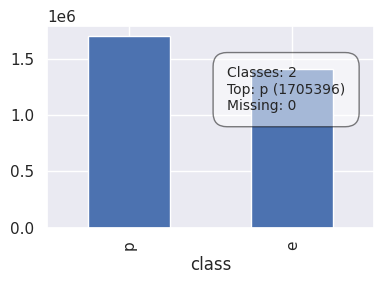

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [ ]:
train_data = pd.read_csv("./data/kaggle_mushroom/train.csv")
test_data = pd.read_csv("./data/kaggle_mushroom/test.csv")

target = "class"
id_column = "id"

target_values = train_data[target].unique().tolist()
features = train_data.drop([id_column, target], axis=1).columns.tolist()

print(f"Target: {target} {target_values}")
print()
print(f"Features ({len(features)}):", features)
print()
print("Nº of train samples:", len(train_data))
print("Nº of test samples:", len(test_data))

# cópia para manipular dados (sem `id` e `class`)
data = train_data.copy().drop(columns=[id_column, target])

plot_features(target, train_data)
data.head()

### Features

O píleo (*cap*) de um cogumelo é uma estrutura semelhante a um chapéu, responsável por dar suporte ao himênio, o tecido portador de esporos. No dataset estão presentes 4 características relacionadas à estipe e mais uma categoria relacinada à esporada:

`cap-diameter`: é um atributo **contínuo** que representa o diametro do píleo, medido em centímetro (cm).

`cap-shape`: atributo **nominal** que representa o formato do píleo. É representado por uma letra, sendo alguns exemplos de categoria:
  - bell ``b``
  - conical ``c``
  - convex ``x``
  - flat ``f``
  - sunken ``s``
  - spherical ``p``
  - others ``o``

``cap-surface``: atributo **nominal** que representa o tipo de superfície da estipe. É representado por uma letra, sendo alguns exemplos de categoria:
  - fibrous ``i``
  - grooves ``g``
  - scaly ``y``
  - smooth ``s``
  - shiny ``h``
  - leathery ``l``
  - silky ``k``
  - sticky ``t``
  - wrinkled ``w``
  - fleshy ``e``

`cap-color`: atributo **nominal** que representa a cor da estipe. É representado por uma letra, sendo alguns exemplos de categoria:
  - brown ``n``
  - buff ``b``
  - gray ``g``
  - green ``r``
  - pink ``p``,
  - purple ``u``
  - red ``e``
  - white ``w``
  - yellow ``y``
  - blue ``l``

``spore-print-color``: atributo **nominal** que representa a cor da esporada ou impressão de esporos de um cogumelo. É representado por uma letra, sendo alguns exemplos de categorias os mesmos de `cap-color`.

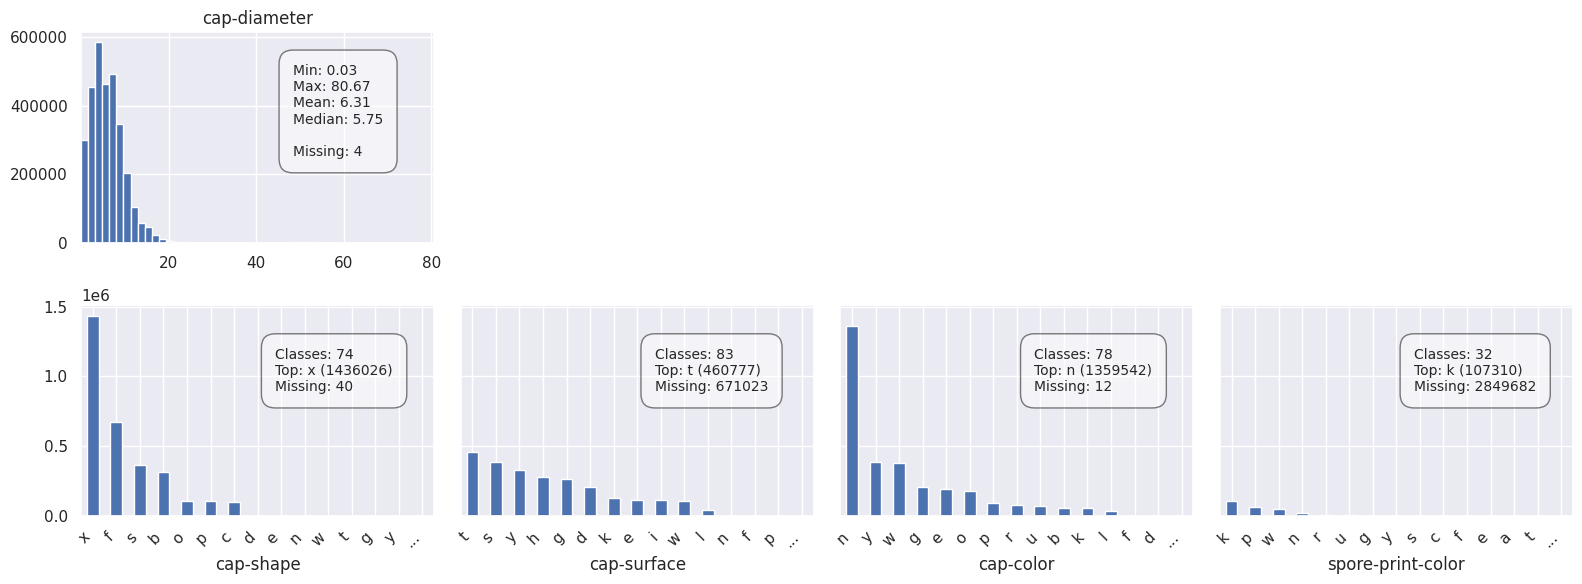

In [7]:
cap_features = [
    "cap-diameter",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "spore-print-color",
]

plot_features(cap_features, data)

A estipe (*stem*) de um cogumelo é uma estrutura semelhante a um caule, suportando seu píleo (chapéu). No dataset estão presentes 5 características relacionadas à estipe:

`stem-height`: é um atributo **contínuo** que representa a altura da estipe, medida em centímetro (cm).

`stem-width`: também um atributo **contínuo** que representa a largura da estipe, medida em milímetro (mm).

`stem-root`: atributo **nominal** que representa o tipo da raiz da estipe. É representado por uma letra, sendo alguns exemplos de categoria:
  - bulbous `b`
  - swollen `s`
  - club `c`
  - cup `u`
  - equal `e`
  - rhizomorphs `z`
  - rooted `r`

``stem-surface``: atributo nominal que representa o tipo de superfície da estipe. É representado por uma letra, sendo alguns exemplos de categorias os mesmoms de ``cap-surface`` mais a categoria *none* `f`.

`stem-color`: atributo **nominal** que representa a cor da estipe. É representado por uma letra, sendo alguns exemplos de categorias os mesmos de `cap-color` mais a categoria *none* `f`.

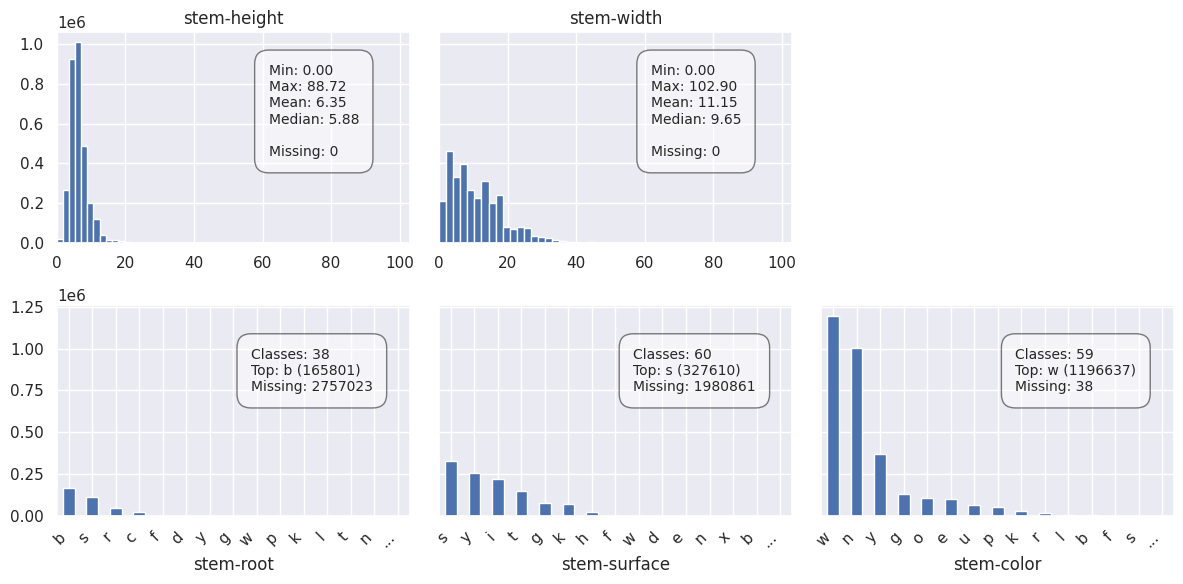

In [8]:
stem_features = ["stem-height", "stem-width", "stem-root", "stem-surface", "stem-color"]

plot_features(stem_features, data)

O véu (*veil*) de um cogumelo é um tecido temporário responsável por proteger as estruturas férteis do cogumelo, como as lamelas (ou poros), durante o seu desenvolvimento. São dois atributos relacionados ao véu presentes nas amostras:

`veil-type`: um atributo **nominal binário** que se refere aos dois possíveis tipos de véus que um cogumelo pode ter, ou parcial `p` ou universal `u`.

`veil-color`: atributo **nominal** que representa a cor do véu. É representado por uma letra, sendo alguns exemplos de categorias os mesmos de `cap-color` mais a categoria *none* `f`.

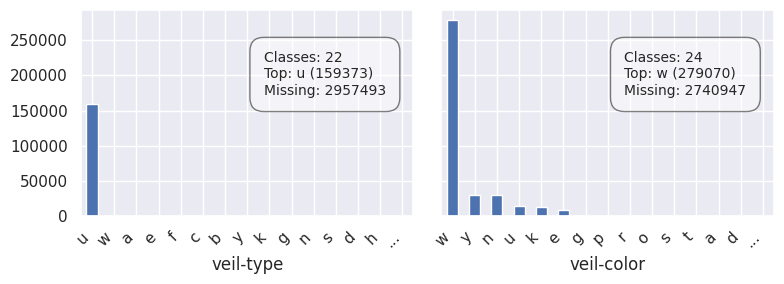

In [9]:
veil_features = ["veil-type", "veil-color"]

plot_features(veil_features, data)

A lamela (*gil*) são as estruturas foliares do himenóforo, tecido dos fungos que suporta o himénio, e são situadas na parte inferior do píleo do cogumelo. O dataset apresenta três características relacionadas à lamela:

`gill-attachment`: atributo **nominal** que representa como as lamelas estão ligadas ao à estipe. É representado por uma letra, sendo alguns exemplos de categoria:
  - adnate `a`
  - adnexed `x`
  - decurrent `d`
  - free `e`
  - sinuate `s`
  - pores `p`
  - *none* `f`
  - *unknown* `?`

`gill-spacing`: atributo **nominal** que representa o espaçamento entre as lamelas. É representado por uma letra, sendo alguns exemplos de categoria:
  - close `c`
  - distant `d`
  - *none* `f`


`gill-color`: atributo **nominal** que representa a cor das lamelas. É representado por uma letra, sendo alguns exemplos de categorias os mesmos de `cap-color` mais a categoria *none* `f`.

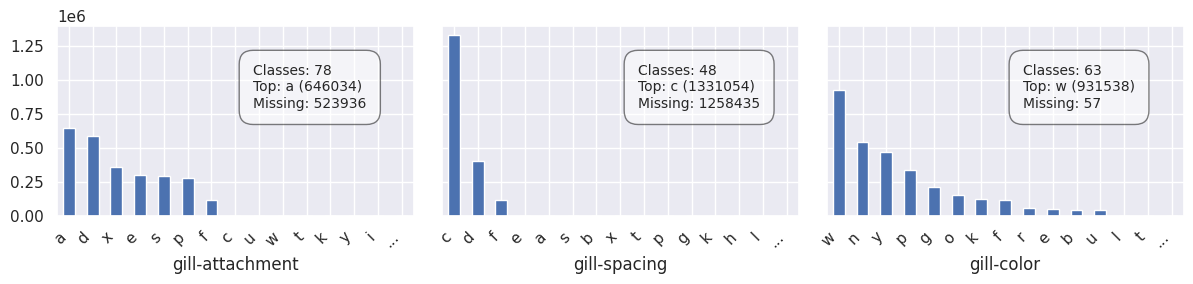

In [10]:
gill_features = ["gill-attachment", "gill-spacing", "gill-color"]

plot_features(gill_features, data)

Um cogumelo pode ou não conter um anél (*ring*), que é uma estrutura  ao redor da estipe de um cogumelo, sendo um resquício do véu parcial. O dataset apresenta duas características relacionadas ao anél:

`has-ring`: atributo **nominal binário** que diz se um cogumelo possui um anél `t` ou não `f`.

`ring-type`: atributo **nominal** que representa diferentes tipos de anél que um cogumelo pode ter, sendo exemplos de categorias presentes no dataset:
  - cobwebby `c`
  - evanescent `e`
  - flaring `r`
  - grooved `g`
  - large `l`
  - pendant `p`
  - sheathing `s`
  - zone `z`
  - scaly `y`
  - movable `m`
  - *none* `f`
  - *unknown* `?`



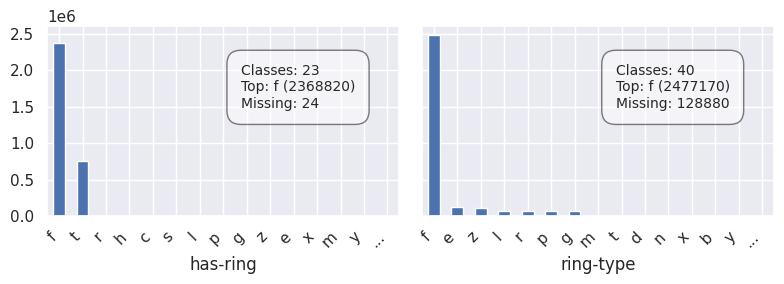

In [11]:
ring_features = ["has-ring", "ring-type"]

plot_features(ring_features, data)

Alguns cogumelos geram "machucados" ou "sangram" quando cortados, nesse sentido, o atributo **nominal binário** `does-bruise-or-bleed` nos diz se isso acontece `t` ou não `f` com uma amostra de cogumelo.

Cogumelos também possuem habitats próprios e aparecem exclusivamente em algumas estações do ano, nesse sentido, estão presentes no dataset:

``habitat``: atributo **nominal** que representa o tipo de habitat em que o cogumelo normalmente cresce. É representado por uma letra, sendo exemplos de categoria:
  - grasses `g`
  - leaves `l`
  - meadows `m`
  - paths `p`
  - heaths `h`
  - urban `u`
  - waste `w`
  - woods `d`

`season`: atributo **nominal** que se refere as quatro estações do ano: primavera (*spring* ``s``), verão (*summer* ``u``), outono (*autumn* ``a``) e inverno (*winter* ``w``).

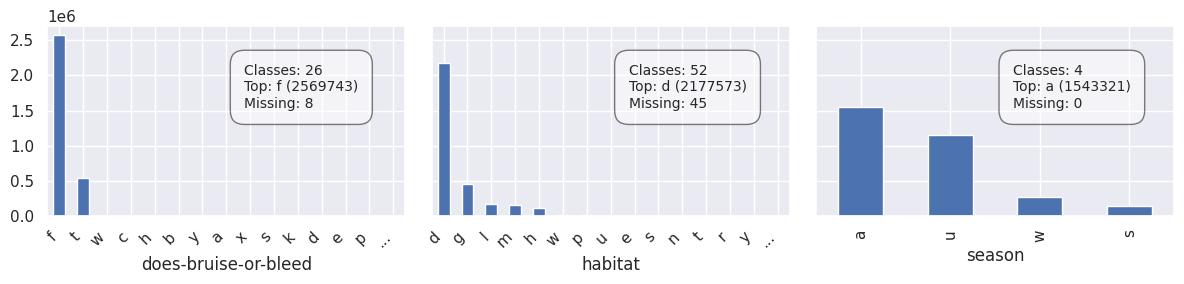

In [12]:
other_features = ["does-bruise-or-bleed", "habitat", "season"]

plot_features(other_features, data)

## Pré-processamento

### Limpeza de dados

O dataset apresenta diversos valores errôneos em diversos atributos. Um exemplo, no atributo `cap-surface`, além dos tipos definidos nos datasets originais (`g`, `h`, `t`, `y`, `e`, `s`, `l`, `d`, `w`, `i`, `k`), existem várias "categorias" errôneas.

In [13]:
data["cap-surface"].unique()

array(['s', 'h', 'y', 'l', 't', 'e', 'g', nan, 'd', 'i', 'w', 'k',
       '15.94', 'f', 'n', 'r', 'o', 'a', 'u', 'z', '2.7', 'does l',
       '5.07', 'p', 'b', 'm', 'cap-diameter', '1.43', 'x', '7.14', 'c',
       'is h', 'does t', '0.85', '6.57', '12.79', '6.45', '4.66', '23.18',
       '3.06', '16.39', '4.21', 'veil-color', '11.78', '8.1', 'has-ring',
       'does h', '1.42', 'class', 'has h', 'does None', '10.83', 'season',
       '8.96', '14.04', '5.73', 'is None', '24.38', '2.81', '0.88',
       '2.11', '2.79', 'ring-type', 'does-bruise-or-bleed', '4.93',
       'spore-print-color', 'spore-color', '2.92', '2.51', '7.99', 'is y',
       '3.64', '3.33', '41.91', '12.2', '8.01', '9.22', '1.14', '6.49',
       '10.34', '10.1', '1.08', 'is k', '0.87'], dtype=object)

Foi abordado uma solução baseada nas categorias dos datasets originais, convertendo valores fora das categorias definidas para `nan`.

In [14]:
secondary_mushroom = pd.read_csv(
    "./data/secondary_mushroom/secondary_data.csv", sep=";"
)

secondary_mushroom.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


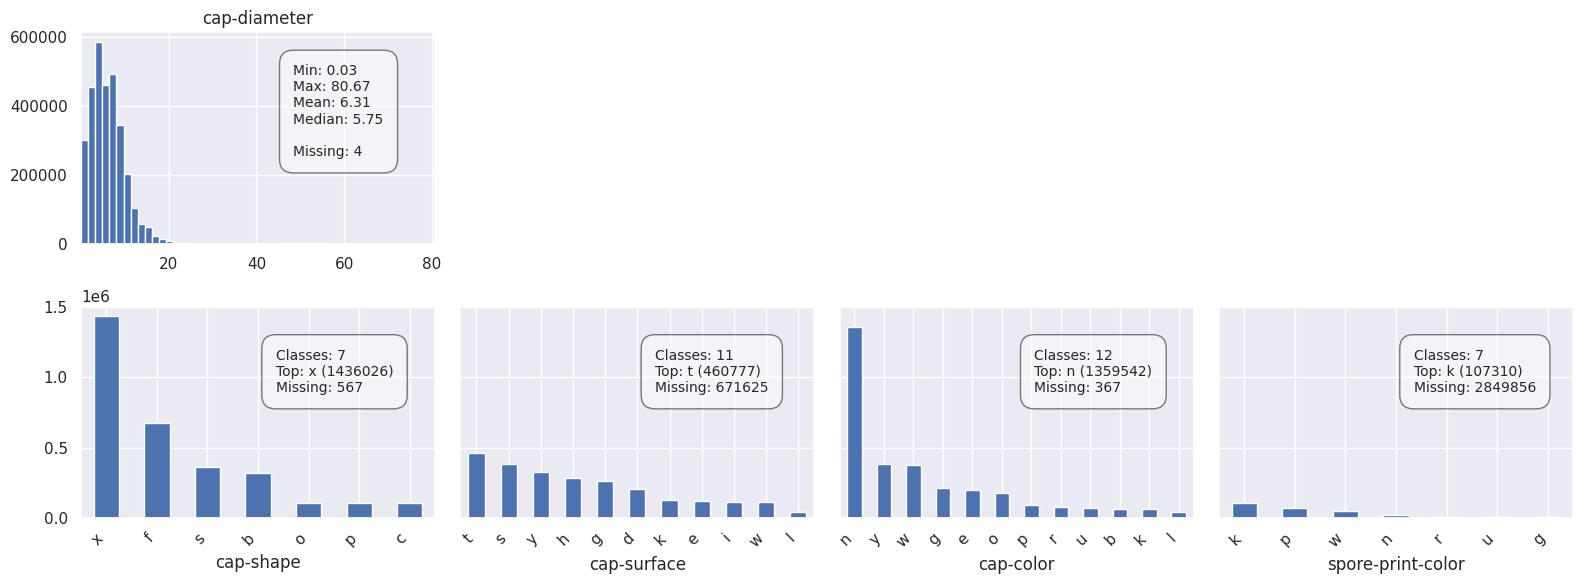

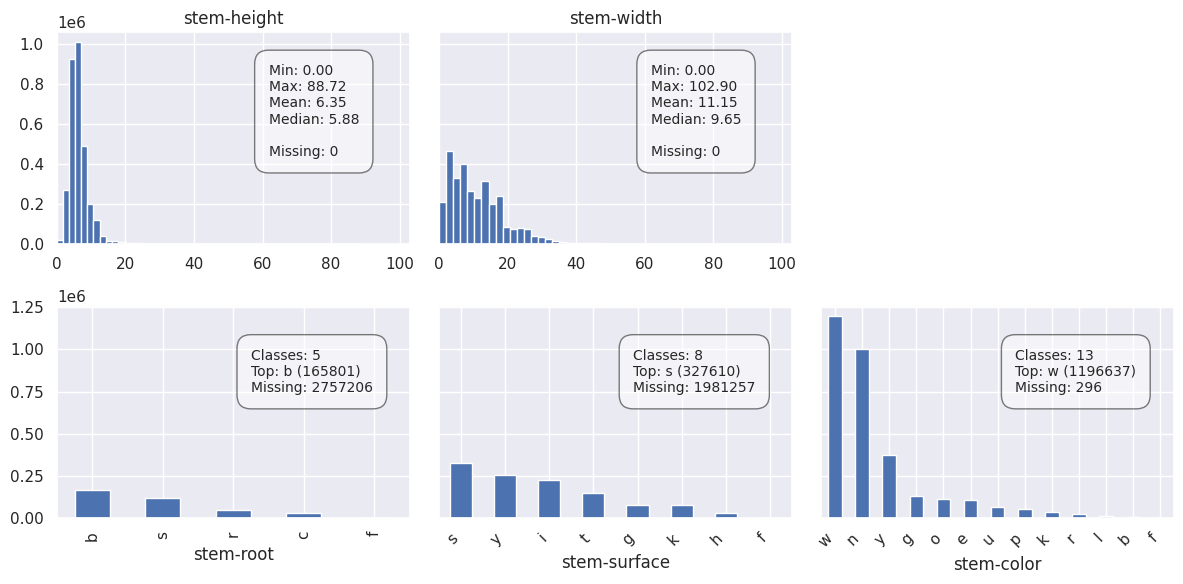

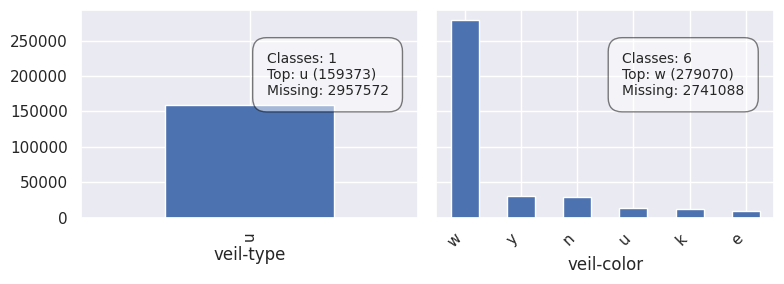

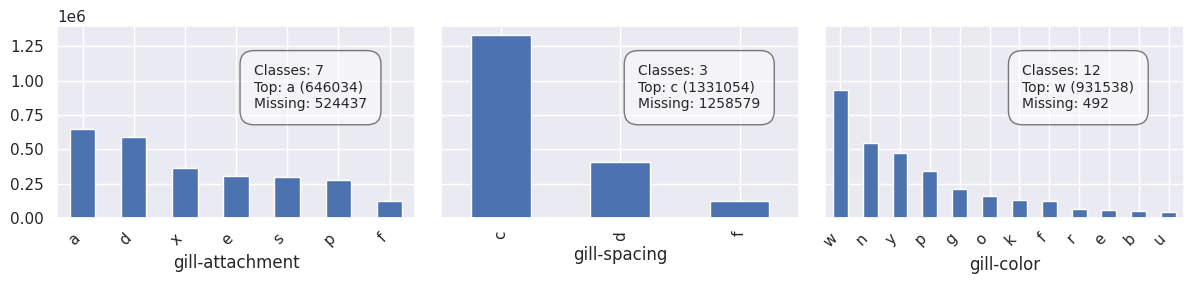

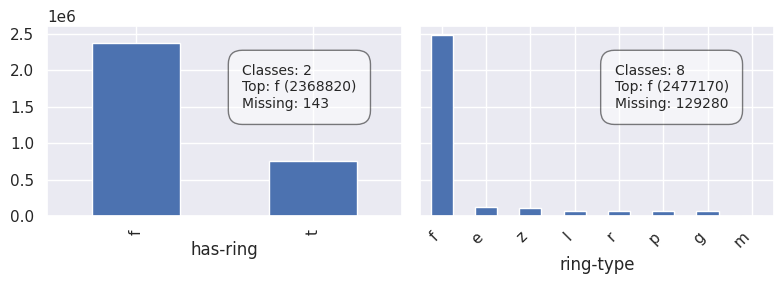

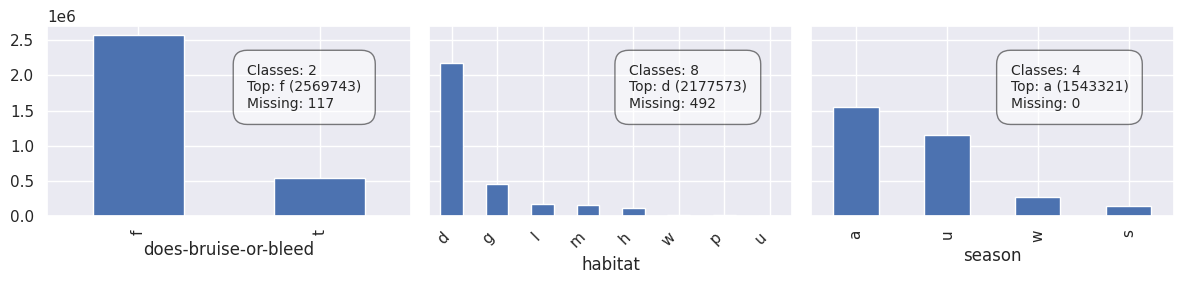

In [ ]:
for feat in secondary_mushroom.select_dtypes(include="object").columns:
    if feat in data.columns:
        valid_values = secondary_mushroom[feat].dropna().unique()
        data[feat] = data[feat].where(data[feat].isin(valid_values))

plot_features(cap_features, data)
plot_features(stem_features, data)
plot_features(veil_features, data)
plot_features(gill_features, data)
plot_features(ring_features, data)
plot_features(other_features, data)

### Preenchimento de valores ausentes

Verificamos a porcentagem de valors ausentes ``NaN`` por atributo.

In [16]:
def get_missing_types_summary(data, only_bigger_than_zero=True):
    def get_category_percentages(column):
        if column.dtype in ["object", "category"]:
            category_counts = column.value_counts(normalize=True) * 100
            return category_counts.round(2).to_dict()
        return {}

    missing_percentages = data.isna().sum() / len(data) * 100
    summary = pd.DataFrame(
        {"Missing (%)": missing_percentages, "Data Type": data.dtypes}
    )
    summary["Category Percentages"] = summary.index.map(
        lambda col: get_category_percentages(data[col])
    )
    summary["Category Percentages"] = summary["Category Percentages"].apply(
        lambda x: (
            {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}
            if x
            else {}
        )
    )
    if only_bigger_than_zero:
        summary = summary[summary["Missing (%)"] > 0.0]

    return summary

In [17]:
get_missing_types_summary(data)

,Missing (%),Data Type,Category Percentages
cap-diameter,0.000128,float64,{}
cap-shape,0.018191,object,"{'x': 46.08, 'f': 21.7, 's': 11.72, 'b': 10.22, 'o': 3.49, 'p': 3.43, 'c': 3.35}"
cap-surface,21.547541,object,"{'t': 18.84, 's': 15.74, 'y': 13.41, 'h': 11.63, 'g': 10.79, 'd': 8.46, 'k': 5.27, 'e': 4.9, 'i': 4.64, 'w': 4.49, 'l': 1.83}"
cap-color,0.011774,object,"{'n': 43.62, 'y': 12.41, 'w': 12.17, 'g': 6.76, 'e': 6.33, 'o': 5.74, 'p': 2.95, 'r': 2.51, 'u': 2.35, 'b': 1.97, 'k': 1.92, 'l': 1.27}"
does-bruise-or-bleed,0.003754,object,"{'f': 82.45, 't': 17.55}"
gill-attachment,16.825353,object,"{'a': 24.92, 'd': 22.73, 'x': 13.92, 'e': 11.64, 's': 11.4, 'p': 10.77, 'f': 4.63}"
gill-spacing,40.378608,object,"{'c': 71.62, 'd': 21.95, 'f': 6.42}"
gill-color,0.015785,object,"{'w': 29.89, 'n': 17.44, 'y': 15.06, 'p': 11.03, 'g': 6.81, 'o': 5.04, 'k': 4.11, 'f': 3.84, 'r': 2.02, 'e': 1.8, 'b': 1.52, 'u': 1.46}"
stem-root,88.458603,object,"{'b': 46.09, 's': 32.51, 'r': 13.29, 'c': 7.95, 'f': 0.17}"
stem-surface,63.564067,object,"{'s': 28.85, 'y': 22.5, 'i': 19.75, 't': 13.03, 'g': 6.88, 'k': 6.46, 'h': 2.49, 'f': 0.05}"


Para os atributos `stem-surface`, `stem-color`, `veil-color`, `gill-attachment`, `gill-spacing`,  `gill-color` e `ring-type`, existe a categoria `f` que representa *none* (nenhuma). Assim, serão atribuídos a categoria `f` para valores ausentes nesses atributos. 

Já o atributo `cap-shape` possui uma categoria *other* (outra) `o`. Utilizaremos ela para preencher valores ausentes nesse atributo.

Para `cap-color`, criaremos a categoria *none* `f` para valores ausentes, como existe em outros atributos relacionados a cor. Como `spore-print-color` segue as mesmas categorias que `cap-color`, o mesmo será atribuído para este último.

In [18]:
def fill_nan(data: pd.DataFrame, feats, value):
    data[feats] = data[feats].fillna(value)
    return data


data = fill_nan(
    data,
    [
        "stem-surface",
        "stem-color",
        "veil-color",
        "gill-attachment",
        "gill-spacing",
        "gill-color",
        "ring-type",
        "cap-color",
        "spore-print-color",
    ],
    "f",
)
data = fill_nan(data, ["cap-shape"], "o")

get_missing_types_summary(data)

,Missing (%),Data Type,Category Percentages
cap-diameter,0.000128,float64,{}
cap-surface,21.547541,object,"{'t': 18.84, 's': 15.74, 'y': 13.41, 'h': 11.63, 'g': 10.79, 'd': 8.46, 'k': 5.27, 'e': 4.9, 'i': 4.64, 'w': 4.49, 'l': 1.83}"
does-bruise-or-bleed,0.003754,object,"{'f': 82.45, 't': 17.55}"
stem-root,88.458603,object,"{'b': 46.09, 's': 32.51, 'r': 13.29, 'c': 7.95, 'f': 0.17}"
veil-type,94.886884,object,{'u': 100.0}
has-ring,0.004588,object,"{'f': 76.0, 't': 24.0}"
habitat,0.015785,object,"{'d': 69.87, 'g': 14.6, 'l': 5.52, 'm': 4.84, 'h': 3.85, 'w': 0.59, 'p': 0.55, 'u': 0.17}"


O atributo `veil-type` é binário, entretanto, apenas um dos valores aparece rotulado: `u` de *universal*. Trataremos o restante dos dados não rotulados como o negativo de `u` (`~u`) , ou seja, a categoria `p` de *partial*. 

In [19]:
data = fill_nan(data, ["veil-type"], "p")

get_missing_types_summary(data)

,Missing (%),Data Type,Category Percentages
cap-diameter,0.000128,float64,{}
cap-surface,21.547541,object,"{'t': 18.84, 's': 15.74, 'y': 13.41, 'h': 11.63, 'g': 10.79, 'd': 8.46, 'k': 5.27, 'e': 4.9, 'i': 4.64, 'w': 4.49, 'l': 1.83}"
does-bruise-or-bleed,0.003754,object,"{'f': 82.45, 't': 17.55}"
stem-root,88.458603,object,"{'b': 46.09, 's': 32.51, 'r': 13.29, 'c': 7.95, 'f': 0.17}"
has-ring,0.004588,object,"{'f': 76.0, 't': 24.0}"
habitat,0.015785,object,"{'d': 69.87, 'g': 14.6, 'l': 5.52, 'm': 4.84, 'h': 3.85, 'w': 0.59, 'p': 0.55, 'u': 0.17}"


Para `habitat` e `does-bruise-or-bleed`, que possui muitos poucos dados faltando, atribuiremos a categoria com maior número de instâncias.

In [20]:
h = data["habitat"].value_counts().idxmax()
data = fill_nan(data, ["habitat"], h)

b = data["does-bruise-or-bleed"].value_counts().idxmax()
data = fill_nan(data, ["does-bruise-or-bleed"], b)

get_missing_types_summary(data)

,Missing (%),Data Type,Category Percentages
cap-diameter,0.000128,float64,{}
cap-surface,21.547541,object,"{'t': 18.84, 's': 15.74, 'y': 13.41, 'h': 11.63, 'g': 10.79, 'd': 8.46, 'k': 5.27, 'e': 4.9, 'i': 4.64, 'w': 4.49, 'l': 1.83}"
stem-root,88.458603,object,"{'b': 46.09, 's': 32.51, 'r': 13.29, 'c': 7.95, 'f': 0.17}"
has-ring,0.004588,object,"{'f': 76.0, 't': 24.0}"


Para `cap-surface` e `stem-root`, criamos uma categoria *other* `o`, similar ao atributo `cap-shape`, e preencheremos os valores faltantes com essa nova categoria.

In [21]:
data = fill_nan(data, ["cap-surface", "stem-root"], "o")

get_missing_types_summary(data)

,Missing (%),Data Type,Category Percentages
cap-diameter,0.000128,float64,{}
has-ring,0.004588,object,"{'f': 76.0, 't': 24.0}"


Para `cap-diameter`, preenchemos com base na média dos valores de outras amostras com características similares para o píleo (*cap*), como `cap-surface`, `cap-shape` e `cap-color`.

In [22]:
def fill_missing_by_group_mean(data, target, references):
    data = data.copy()

    ref_combinations = [references[:i] for i in range(len(references), 0, -1)]

    group_means_dict = {
        tuple(refs): data.groupby(refs)[target].mean() for refs in ref_combinations
    }
    global_mean = data[target].mean()

    def fill_aux(row):
        if pd.isna(row[target]):
            for refs in ref_combinations:
                key = tuple(row[ref] for ref in refs)
                val = group_means_dict[tuple(refs)].get(key, np.nan)
                if not pd.isna(val):
                    return val
            return global_mean
        return row[target]

    data[target] = data.apply(fill_aux, axis=1)
    return data


data = fill_missing_by_group_mean(
    data, "cap-diameter", ["cap-surface", "cap-shape", "cap-color"]
)

get_missing_types_summary(data)

,Missing (%),Data Type,Category Percentages
has-ring,0.004588,object,"{'f': 76.0, 't': 24.0}"


O atributo `has-ring` é relacionado com o atributo `ring-type`, onde `f` significa a ausência de anéis e `?` um anél desconhecido (nenhuma instância nos dados). Assim, para valores de uma isntância onde `ring-type` é igual a `f`, `has-ring` será também `f`, se não `t`.

In [23]:
def fill_has_ring(data):
    data["has-ring"] = data["ring-type"].apply(lambda rt: "f" if rt == "f" else "t")
    return data


data = fill_has_ring(data)

get_missing_types_summary(data)

,Missing (%),Data Type,Category Percentages


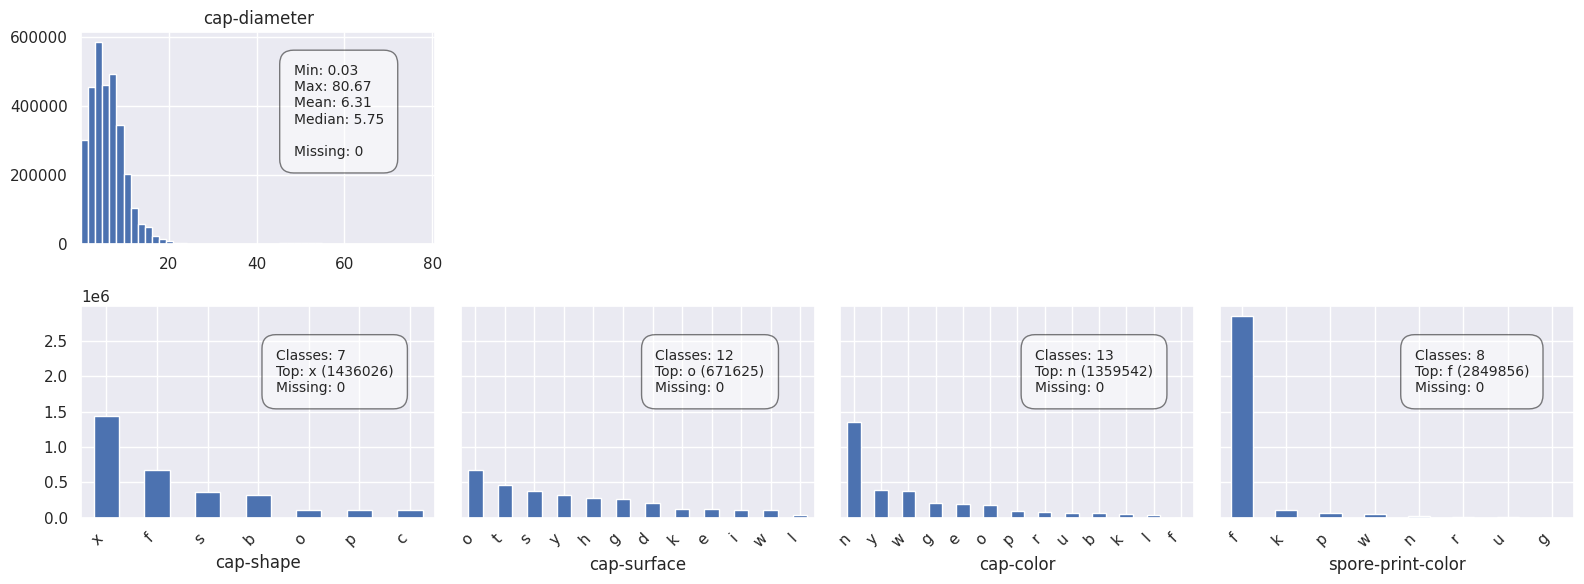

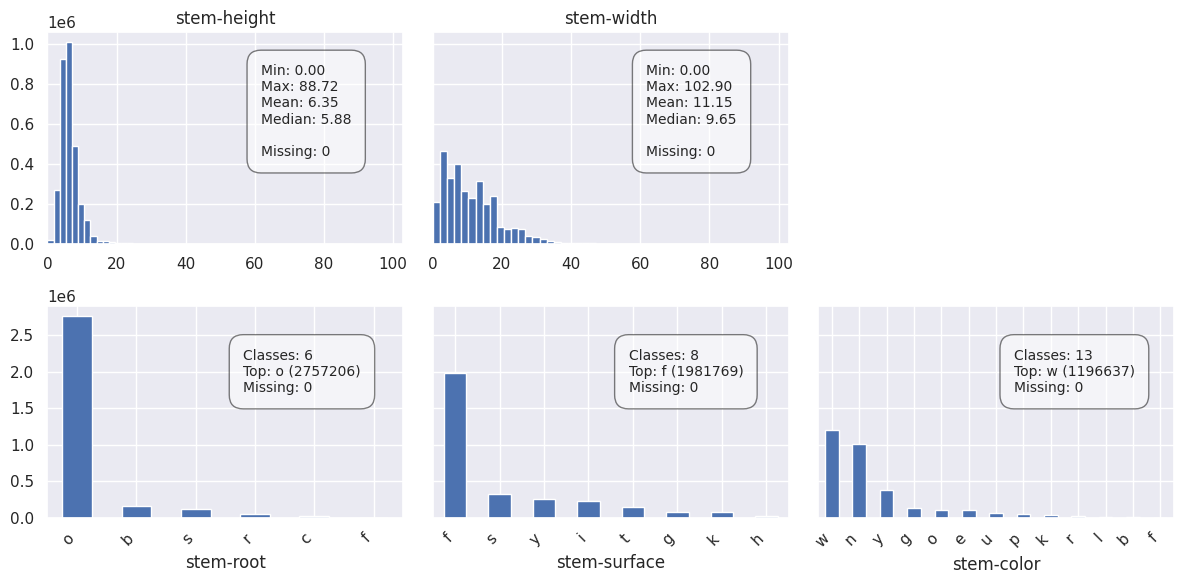

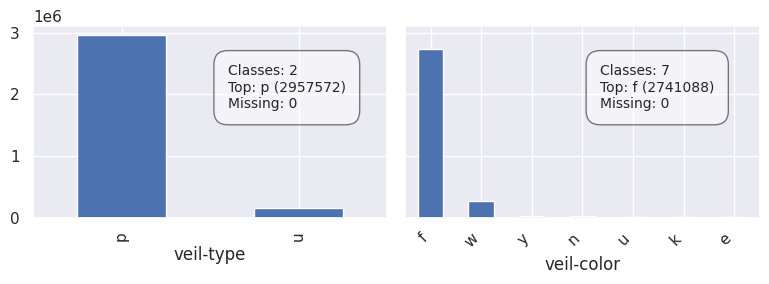

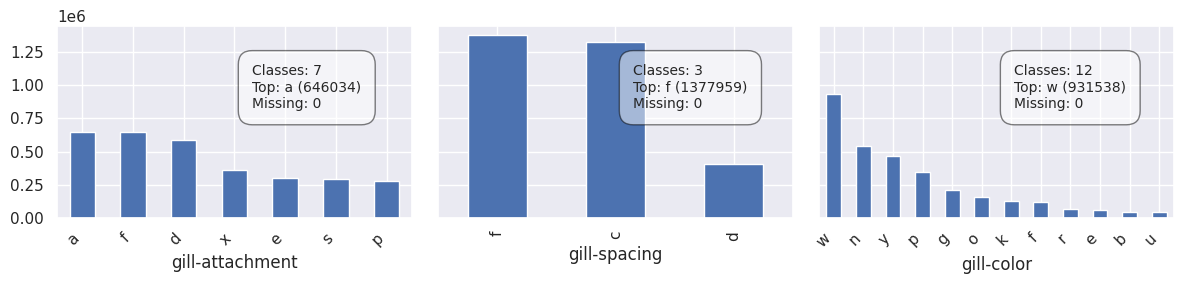

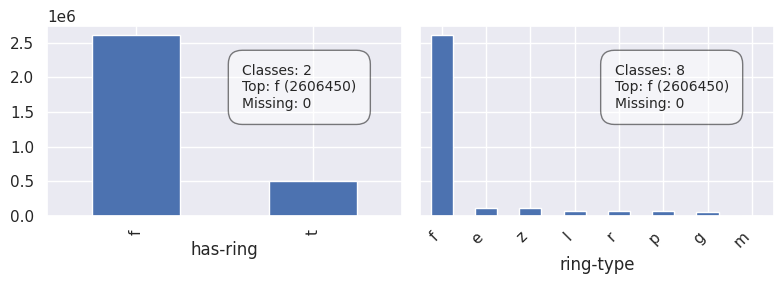

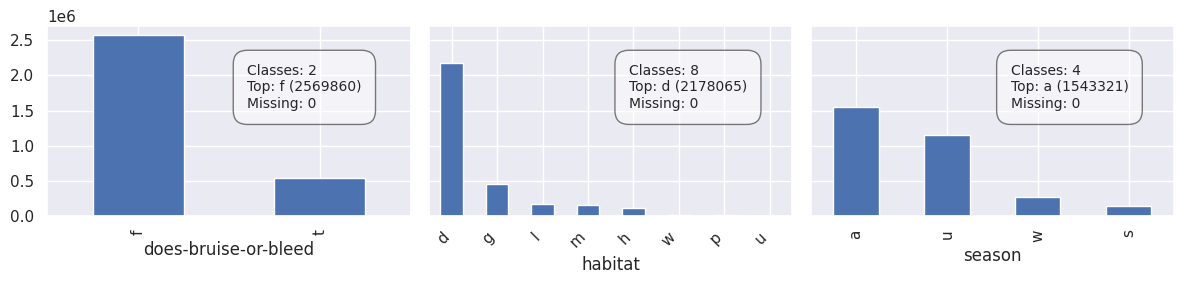

In [ ]:
plot_features(cap_features, data)
plot_features(stem_features, data)
plot_features(veil_features, data)
plot_features(gill_features, data)
plot_features(ring_features, data)
plot_features(other_features, data)

### Transformação dos dados

Atributos **contínuos** são padronizados utilizando *Z-score normalization* (`StandardScaler`).

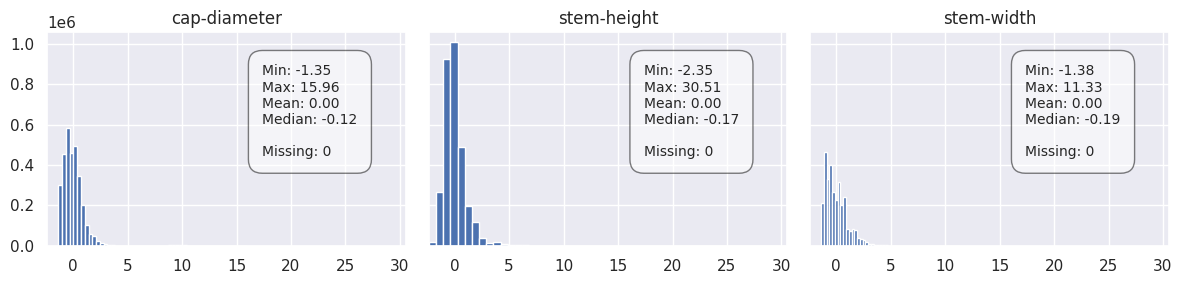

In [25]:
continous_features = ["cap-diameter", "stem-height", "stem-width"]

standard_scalers = {}

for feat in continous_features:
    scaler = StandardScaler()
    standard_scalers[feat] = scaler
    data[feat] = scaler.fit_transform(data[[feat]])

plot_features(continous_features, data)

Para os atributos **nominais binários**, atribuímos as classes como verdadeiro `1` ou falso `0`.

`veil-type`: `p`, `u` $\rightarrow$ `0`, `1`

`has-ring`: `f`, `t` $\rightarrow$ `0`, `1`

`does-bruise-or-bleed`: `f`, `t` $\rightarrow$ `0`, `1`

In [26]:
binary_features = ["veil-type", "has-ring", "does-bruise-or-bleed"]

data["veil-type"] = data["veil-type"].map({"p": 0, "u": 1}).astype("object")
data["has-ring"] = data["has-ring"].map({"f": 0, "t": 1}).astype("object")
data["does-bruise-or-bleed"] = (
    data["does-bruise-or-bleed"].map({"f": 0, "t": 1}).astype("object")
)

data[binary_features].describe()

,veil-type,has-ring,does-bruise-or-bleed
count,3116945,3116945,3116945
unique,2,2,2
top,0,0,0
freq,2957572,2606450,2569860


Atributos **nominais** relacionados a cores utilizaram o mesmo *encoder*.

In [27]:
colors = ["n", "b", "g", "r", "p", "u", "e", "w", "y", "l", "o", "k", "f"]

color_encoder = LabelEncoder()
color_encoder.fit(colors)

colors_features = [
    "cap-color",
    "stem-color",
    "veil-color",
    "gill-color",
    "spore-print-color",
]

for feat in colors_features:
    data[feat] = color_encoder.transform(data[feat]).astype("object")

data[colors_features].describe()

,cap-color,stem-color,veil-color,gill-color,spore-print-color
count,3116945,3116945,3116945,3116945,3116945
unique,13,13,7,12,8
top,6,11,2,11,2
freq,1359542,1196637,2741088,931538,2849856


Atributos **nominais** relacionados a superfície utilizaram o mesmo *encoder*.

In [28]:
surface_features = ["cap-surface", "stem-surface"]
surfaces = ["i", "g", "y", "s", "h", "l", "k", "t", "w", "e", "o", "f", "d"]

surface_encoder = LabelEncoder()
surface_encoder.fit(surfaces)

for feat in surface_features:
    data[feat] = surface_encoder.transform(data[feat]).astype("object")

data[surface_features].describe()

,cap-surface,stem-surface
count,3116945,3116945
unique,12,8
top,8,2
freq,671625,1981769


Os demais atributos **nominais** utilizam seus próprios *encoders*.

In [ ]:
other_nominal_features = [
    feat
    for feat in data
    if feat
    not in binary_features + colors_features + surface_features + continous_features
]

encoders_map = {}

for feat in other_nominal_features:
    encoder = LabelEncoder()
    encoders_map[feat] = encoder  # saved for later use
    data[feat] = encoder.fit_transform(data[feat]).astype("object")

data.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0.534605,2,9,10,0,0,0,11,-0.680926,0.523282,3,2,11,0,2,0,1,2,0,0
1,-0.386405,6,4,7,0,0,0,6,-0.577213,-0.577333,3,12,7,0,2,1,7,2,0,3
2,0.135286,2,9,0,0,6,0,11,0.185819,-0.151169,3,9,6,0,2,0,1,2,3,3
3,-0.521659,2,12,3,0,5,2,3,-0.810568,-0.571157,3,2,11,0,2,0,1,2,0,2
4,-0.098724,6,7,11,0,1,2,11,-1.103187,-0.345105,3,2,11,0,2,0,1,2,1,0


### Detecção de *outliers*

Os atributos **contínuos** passarão por detecção de outliers utilizando `z score` com threshold igual a `3`, sendo transformados da seguinte maneira:
- Valores detectados como outliers foram convertidos para `nan`.
- Os valores convertidos para `nan` foram gerados como uma média dos valores de outras instâncias com catacterísticas similares sobre uma mesma estrutura de cogumelos (*cap* ou *stem*).

Nº de outliers detectados em cap-diameter: 22773
Corrigindo utilizando como referência: ['cap-shape', 'cap-surface', 'cap-color']
Nº de outliers detectados em stem-height: 51239
Corrigindo utilizando como referência: ['stem-width', 'stem-root', 'stem-surface', 'stem-color']
Nº de outliers detectados em stem-width: 31145
Corrigindo utilizando como referência: ['stem-height', 'stem-root', 'stem-surface', 'stem-color']


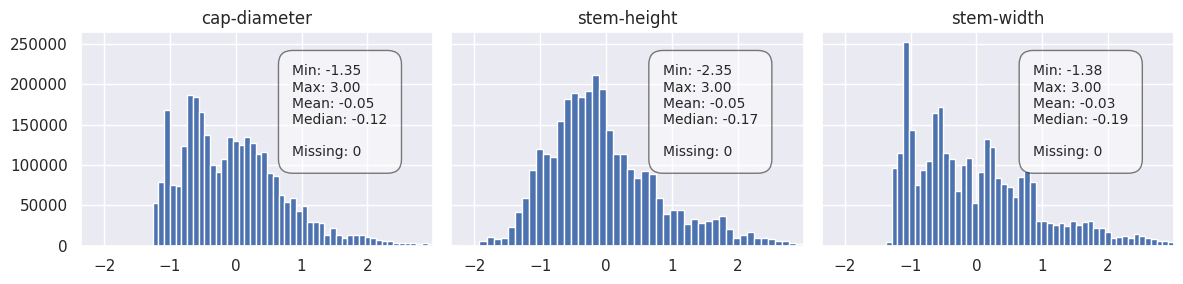

In [ ]:
def detect_outliers_zscore(series, threshold=3):
    z_scores = zscore(series.dropna())
    outlier_mask = pd.Series(False, index=series.index)
    outlier_mask[series.dropna().index] = np.abs(z_scores) > threshold
    return outlier_mask


for feat in continous_features:
    outliers = detect_outliers_zscore(data[feat])
    print(f"Nº de outliers detectados em {feat}:", outliers.sum())
    references = [t for t in data.columns if feat.split("-")[0] in t and t != feat]
    print("Corrigindo utilizando como referência:", references)
    data.loc[outliers, feat] = np.nan
    data = fill_missing_by_group_mean(data, feat, references)

plot_features(continous_features, data)

### Correlação de atributos

In [31]:
correlation = data.corr()

threshold = 0.25
high_corr = correlation[(correlation > threshold) & (correlation < 1.0)]
high_corr = high_corr.dropna(how="all").dropna(axis=1, how="all")
high_corr

,cap-diameter,cap-color,does-bruise-or-bleed,stem-height,stem-width,stem-color,veil-type,veil-color,has-ring,ring-type
cap-diameter,NaN,NaN,0.334983,0.465005,0.802498,NaN,NaN,NaN,NaN,NaN
cap-color,NaN,NaN,NaN,NaN,NaN,0.264588,NaN,NaN,NaN,NaN
does-bruise-or-bleed,0.334983,NaN,NaN,NaN,0.305651,NaN,NaN,NaN,NaN,NaN
stem-height,0.465005,NaN,NaN,NaN,0.399591,NaN,0.385469,0.369226,0.277443,NaN
stem-width,0.802498,NaN,0.305651,0.399591,NaN,NaN,NaN,NaN,NaN,NaN
stem-color,NaN,0.264588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
veil-type,NaN,NaN,NaN,0.385469,NaN,NaN,NaN,0.673896,0.452483,NaN
veil-color,NaN,NaN,NaN,0.369226,NaN,NaN,0.673896,NaN,0.478060,0.266442
has-ring,NaN,NaN,NaN,0.277443,NaN,NaN,0.452483,0.478060,NaN,0.686665
ring-type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.266442,0.686665,NaN


Como já era observado, `has-ring` e `ring-type` possuem uma forte correlação, inclusive `has-ring` está contido em `ring-type`. Dessa forma, podemos excluir o atributo `has-ring` dos dados.

In [32]:
features_to_remove = ["has-ring"]

A seguir são apresentados graficamente as relações entre os diferentes atributos com o atributo a ser classificado.

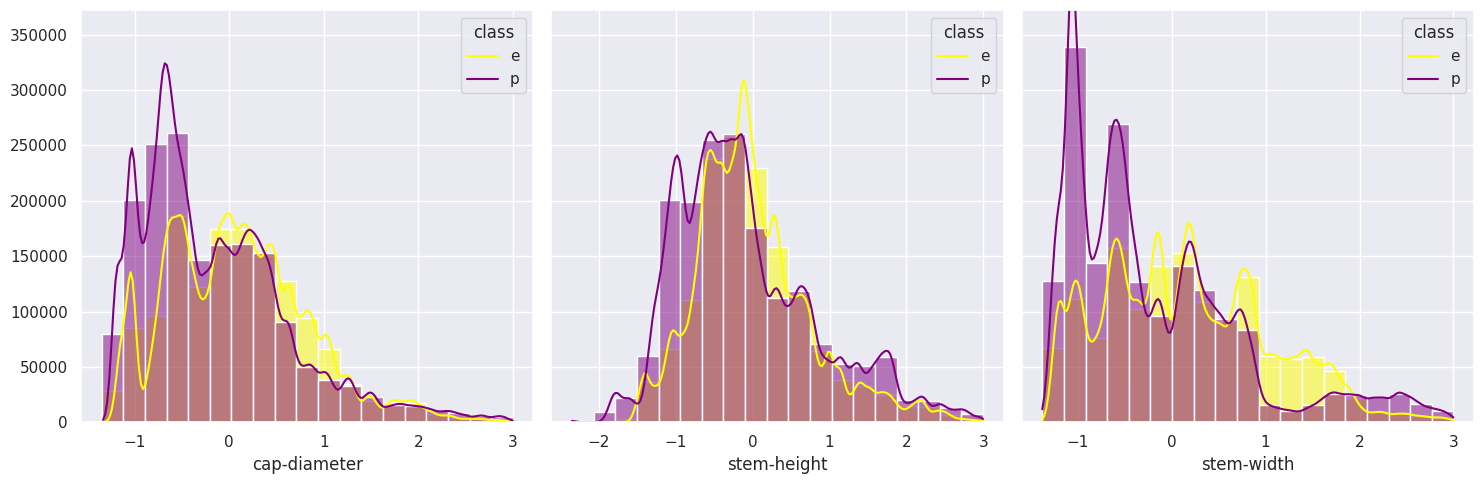

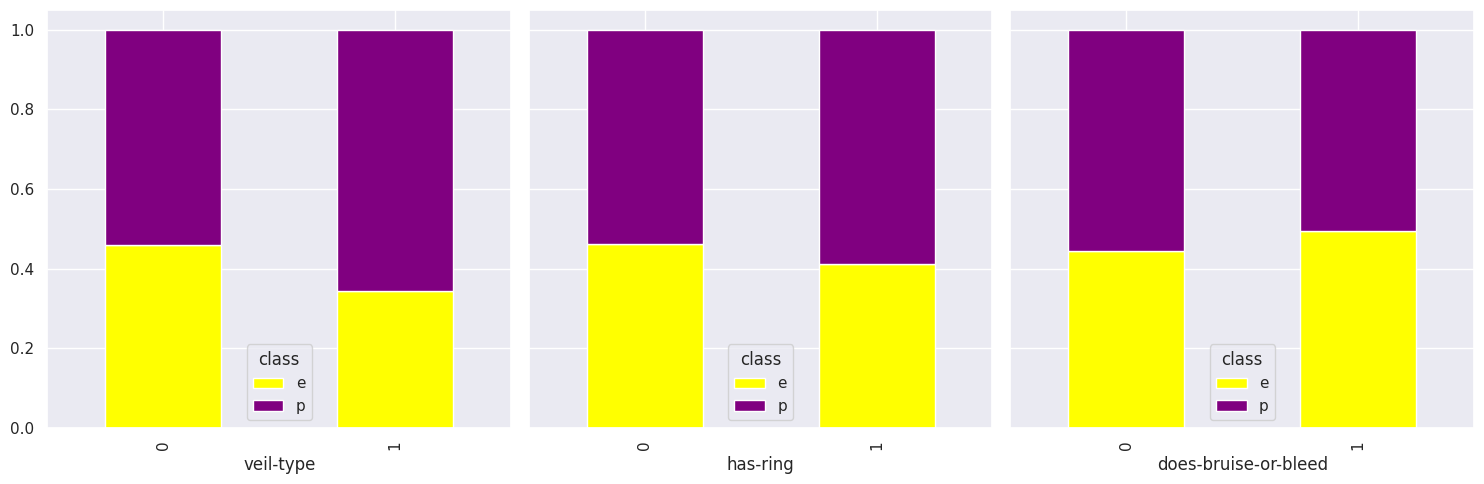

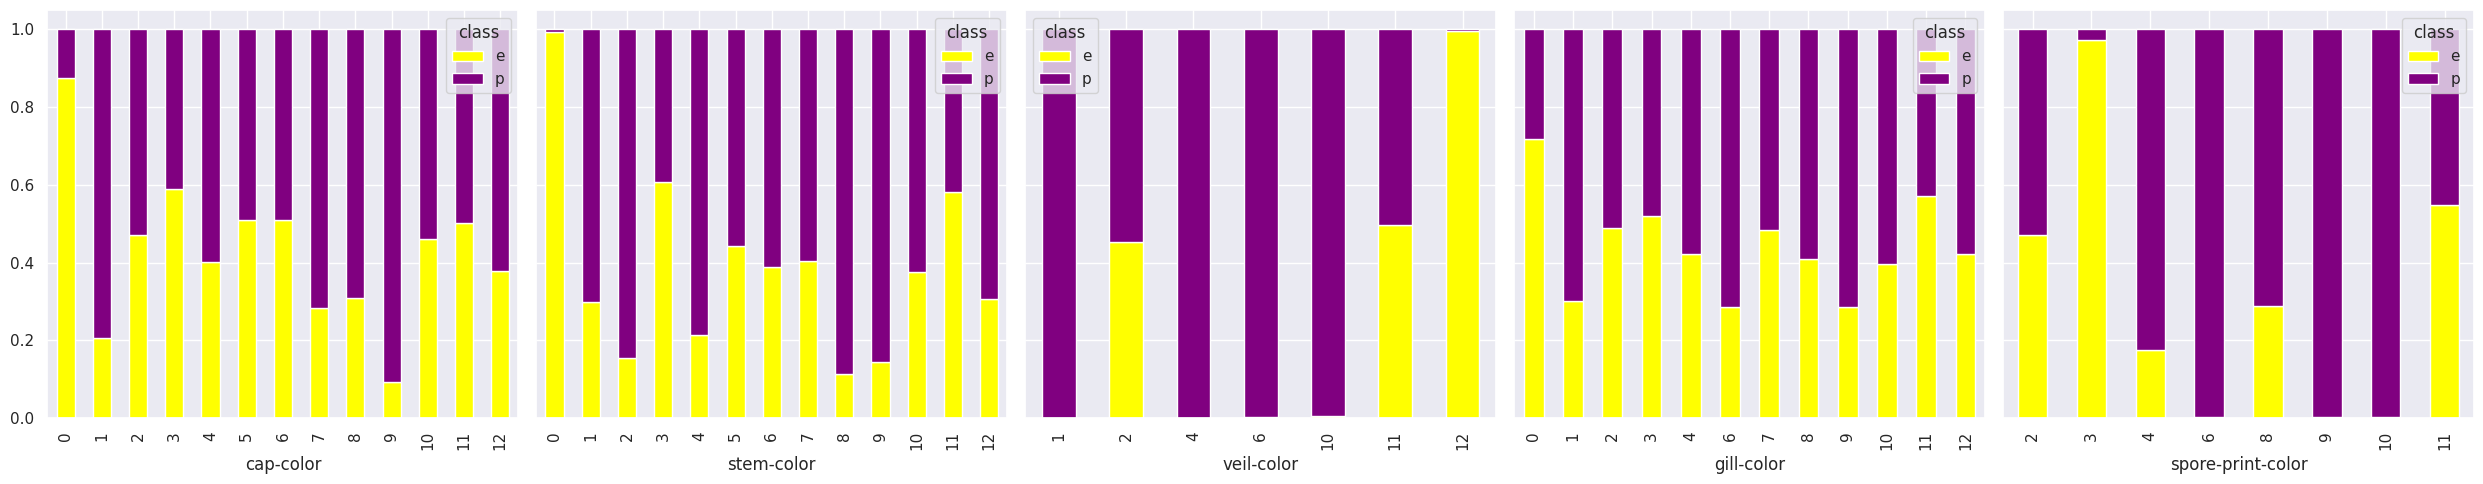

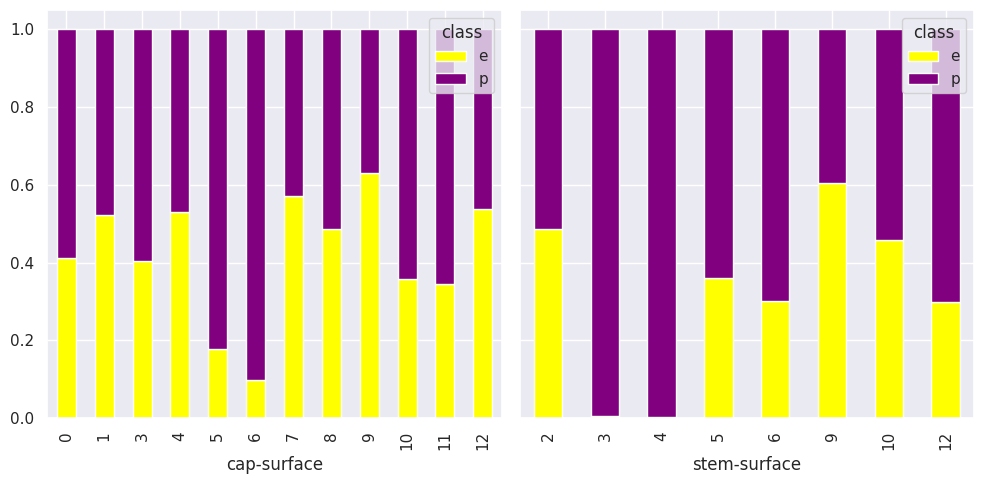

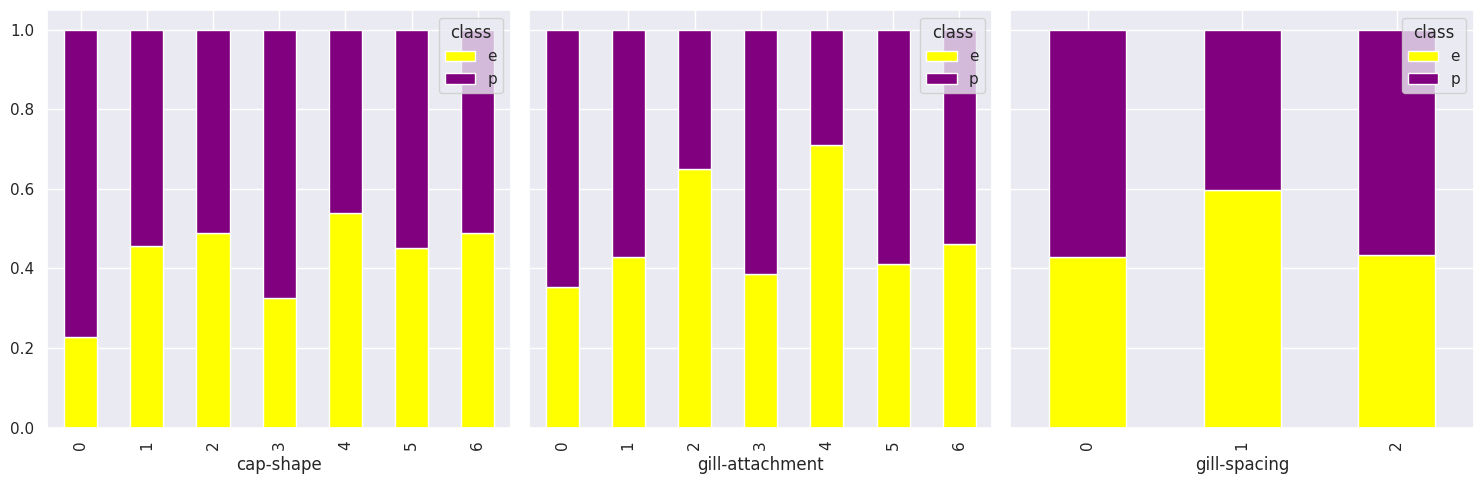

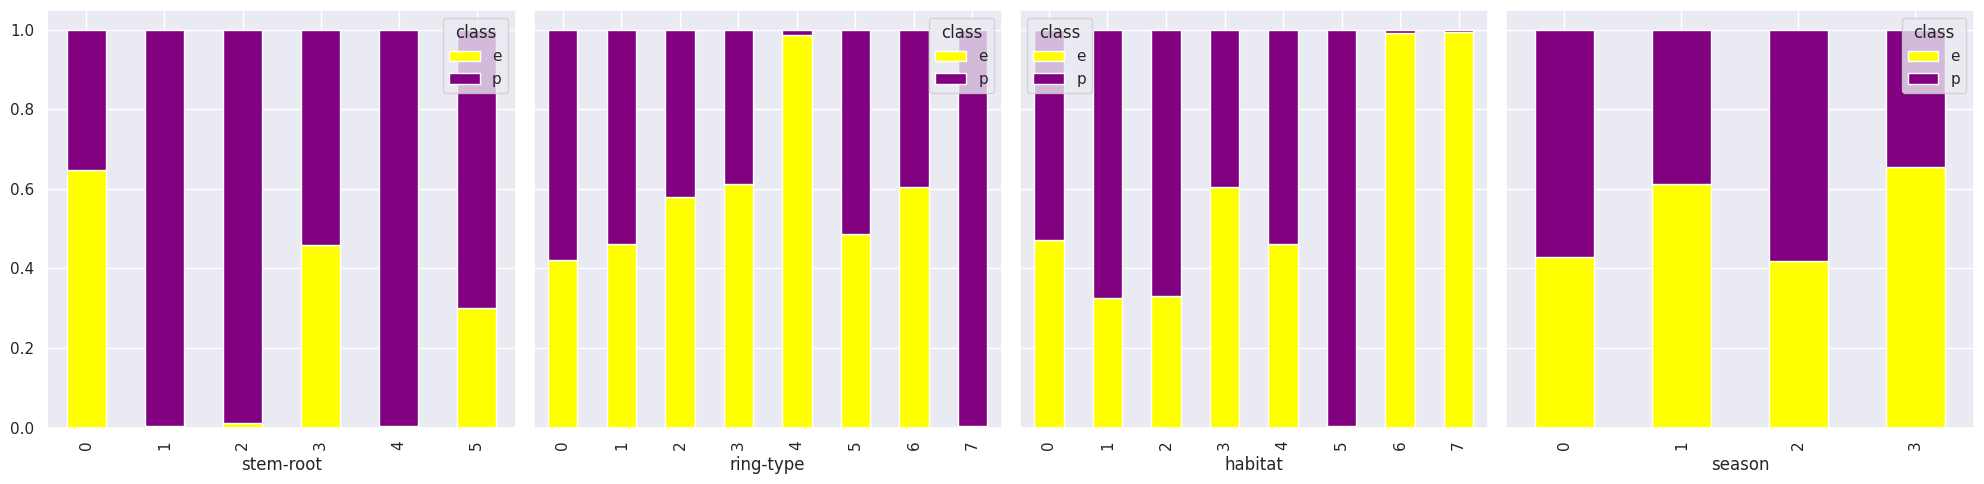

In [33]:
bivariate_analysis(data[continous_features], train_data[target])
bivariate_analysis(data[binary_features], train_data[target])
bivariate_analysis(data[colors_features], train_data[target])
bivariate_analysis(data[surface_features], train_data[target])
bivariate_analysis(data[other_nominal_features[:3]], train_data[target])
bivariate_analysis(data[other_nominal_features[3:]], train_data[target])

Atributos como `veil-color`, `spore-print-color`, `stem-surface` e `stem-root` apresentam viés para a classe `p` (venenoso), dessa forma, é interesasante fazer a remoção dessas classes para evitar vazamento de dados sobre o modelo preditivo.

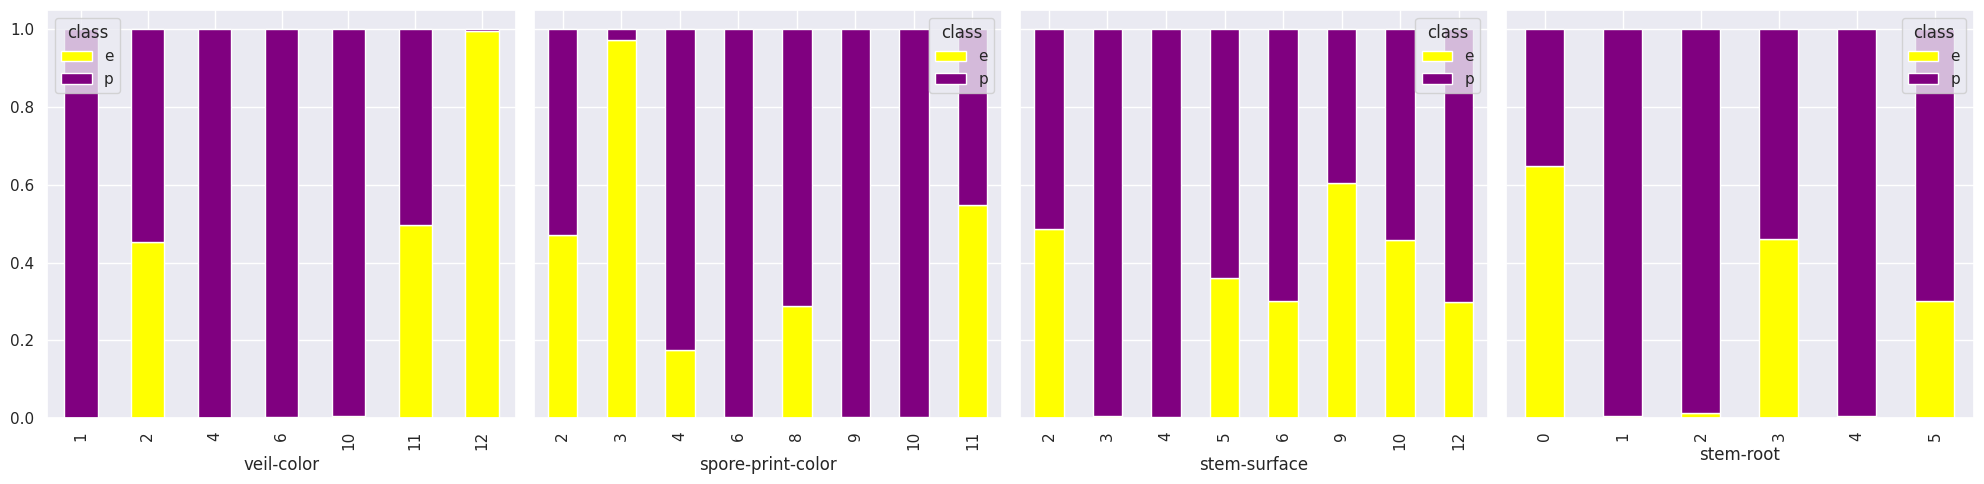

In [34]:
bias_features = ["veil-color", "spore-print-color", "stem-surface", "stem-root"]
features_to_remove += bias_features

bivariate_analysis(data[bias_features], train_data[target])

Os atributos `ring-type` e `habitat` também possuem viés, mas para ambas as classes `e` e `p`. Assim, combinamos categorias desses atributos em uma classe *other* `o`, a fim de diminuir o viés.

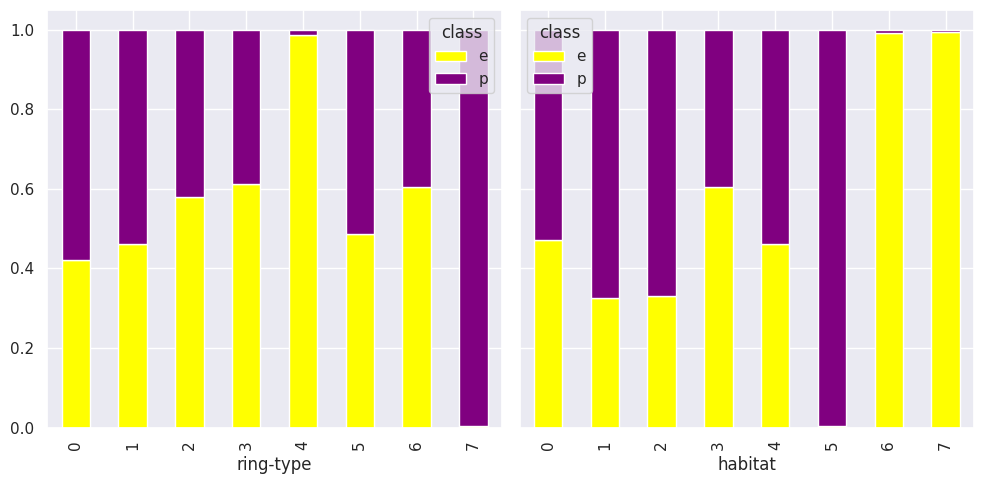

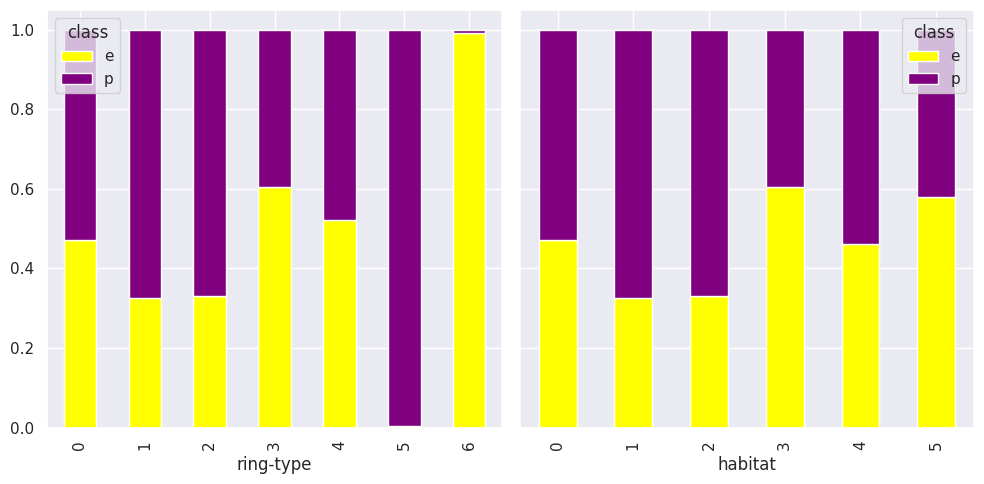

In [35]:
bias_features_balanced = ["ring-type", "habitat"]
bivariate_analysis(data[bias_features_balanced], train_data[target])

data["ring-type"] = data["habitat"].replace({7: 4}).astype("object")
data["habitat"] = data["habitat"].replace({6: 5, 7: 5}).astype("object")

bivariate_analysis(data[bias_features_balanced], train_data[target])

Nosso dataset pré-processado:

In [ ]:
data = data.drop(columns=features_to_remove)

data.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,veil-type,ring-type,habitat,season
0,0.534605,2,9,10,0,0,0,11,-0.680926,0.523282,11,0,0,0,0
1,-0.386405,6,4,7,0,0,0,6,-0.577213,-0.577333,7,0,0,0,3
2,0.135286,2,9,0,0,6,0,11,0.185819,-0.151169,6,0,3,3,3
3,-0.521659,2,12,3,0,5,2,3,-0.810568,-0.571157,11,0,0,0,2
4,-0.098724,6,7,11,0,1,2,11,-1.103187,-0.345105,11,0,1,1,0


## Pipeline

Com base nos processos descritos e implementados, criamos uma função única capaz de receber dataset bruto e retorná-lo pré-processado.

In [ ]:
def preprocess_mushroom_dataset(data):
    steps = [
        "Removing unused columns",
        "Cleaning data",
        "Filling missing values",
        "Transforming data",
        "Detecting outliers",
        "Removing bias",
    ]
    pbar = tqdm(total=len(steps))

    # remoção de colunas não utilizadas
    pbar.set_description(f"Preprocessing dataset ({steps[0]})")
    columns_to_drop = ["id"] + [
        "has-ring",
        "veil-color",
        "spore-print-color",
        "stem-surface",
        "stem-root",
    ]
    target = None
    if "class" in data:
        columns_to_drop.append("class")
        target = pd.DataFrame(data["class"])
    data = data.drop(columns=columns_to_drop)
    pbar.update(1)

    # limpeza de dados
    pbar.set_description(f"Preprocessing dataset ({steps[1]})")
    secondary_mushroom = pd.read_csv(
        "./data/secondary_mushroom/secondary_data.csv", sep=";"
    )
    for feat in tqdm(
        secondary_mushroom.select_dtypes(include="object").columns,
        desc="Validating categorical values",
        leave=False,
    ):
        if feat in data.columns:
            valid_values = secondary_mushroom[feat].dropna().unique()
            data[feat] = data[feat].where(data[feat].isin(valid_values))
    pbar.update(1)

    # preenchimento de dados faltantes
    pbar.set_description(f"Preprocessing dataset ({steps[2]})")
    data = fill_nan(
        data,
        [
            "stem-color",
            "gill-attachment",
            "gill-spacing",
            "gill-color",
            "ring-type",
            "cap-color",
        ],
        "f",
    )
    data = fill_nan(data, ["cap-shape"], "o")
    data = fill_nan(data, ["veil-type"], "p")
    h = data["habitat"].value_counts().idxmax()
    data = fill_nan(data, ["habitat"], h)
    b = data["does-bruise-or-bleed"].value_counts().idxmax()
    data = fill_nan(data, ["does-bruise-or-bleed"], b)
    data = fill_nan(data, ["cap-surface"], "o")
    data = fill_missing_by_group_mean(
        data, "cap-diameter", ["cap-surface", "cap-shape", "cap-color"]
    )
    pbar.update(1)

    # transformações dos dados
    pbar.set_description(f"Preprocessing dataset ({steps[3]})")
    ## dados contínuos
    continous_features = ["cap-diameter", "stem-height", "stem-width"]
    for feat in tqdm(
        continous_features, desc="Scaling continuous features", leave=False
    ):
        scaler = standard_scalers[feat]
        data[feat] = scaler.transform(data[[feat]])
    ## dados binários
    data["veil-type"] = data["veil-type"].map({"p": 0, "u": 1}).astype("object")
    data["does-bruise-or-bleed"] = (
        data["does-bruise-or-bleed"].map({"f": 0, "t": 1}).astype("object")
    )
    ## nominais
    ### colors
    colors_features = [
        "cap-color",
        "stem-color",
        "gill-color",
    ]
    for feat in tqdm(colors_features, desc="Encoding color features", leave=False):
        data[feat] = color_encoder.transform(data[feat]).astype("object")
    ### surface
    data["cap-surface"] = surface_encoder.transform(data["cap-surface"]).astype(
        "object"
    )
    ### outros
    other_nominal_features = [
        "cap-shape",
        "gill-attachment",
        "gill-spacing",
        "ring-type",
        "habitat",
        "season",
    ]
    for feat in tqdm(
        other_nominal_features, desc="Encoding other nominal features", leave=False
    ):
        encoder = encoders_map[feat]
        data[feat] = encoder.transform(data[feat]).astype("object")
    pbar.update(1)

    # detecção de outliers
    pbar.set_description(f"Preprocessing dataset ({steps[4]})")
    for feat in tqdm(
        continous_features, desc="Detecting and correcting outliers", leave=False
    ):
        outliers = detect_outliers_zscore(data[feat])
        references = [t for t in data.columns if feat.split("-")[0] in t and t != feat]
        data.loc[outliers, feat] = np.nan
        data = fill_missing_by_group_mean(data, feat, references)
    pbar.update(1)

    # remoção de viés
    pbar.set_description(f"Preprocessing dataset ({steps[5]})")
    data["ring-type"] = data["habitat"].replace({7: 4}).astype("object")
    data["habitat"] = data["habitat"].replace({6: 5, 7: 5}).astype("object")
    pbar.update(1)

    pbar.close()
    return data, target

### Pré-processamento do dataset de treino

In [ ]:
preprocessed_train_data, train_target = preprocess_mushroom_dataset(train_data)

preprocessed_train_data.head()

Preprocessing dataset (Removing bias): 100%|██████████| 6/6 [01:58<00:00, 19.69s/it]          


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,veil-type,ring-type,habitat,season
0,0.534605,2,9,10,0,0,0,11,-0.680926,0.523282,11,0,0,0,0
1,-0.386405,6,4,7,0,0,0,6,-0.577213,-0.577333,7,0,0,0,3
2,0.135286,2,9,0,0,6,0,11,0.185819,-0.151169,6,0,3,3,3
3,-0.521659,2,12,3,0,5,2,3,-0.810568,-0.571157,11,0,0,0,2
4,-0.098724,6,7,11,0,1,2,11,-1.103187,-0.345105,11,0,1,1,0


### Pré-processamento do dataset de teste

In [ ]:
preprocessed_test_data, test_target = preprocess_mushroom_dataset(test_data)

preprocessed_test_data.head()

Preprocessing dataset (Removing bias): 100%|██████████| 6/6 [01:21<00:00, 13.54s/it]          


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,veil-type,ring-type,habitat,season
0,0.500255,6,8,6,1,3,2,11,1.771149,0.736981,11,1,0,0,0
1,0.126698,3,10,7,0,3,0,12,-1.881035,-0.049878,6,0,0,0,0
2,-0.925272,0,3,6,0,3,0,6,-0.062351,-0.989909,6,0,0,0,1
3,-0.609681,6,10,6,0,5,0,6,-0.506836,-0.326576,11,0,0,0,2
4,-0.030024,6,4,12,0,4,2,12,0.141371,0.314523,12,0,0,0,2


## Referências

Reade W., Chow A. (2024). Kaggle. Binary Prediction of Poisonous Mushrooms. https://kaggle.com/competitions/playground-series-s4e8.

Mushroom [Dataset]. (1981). UCI Machine Learning Repository. https://doi.org/10.24432/C5959T.

Wagner, D., Heider, D., & Hattab, G. (2021). Secondary Mushroom [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5FP5Q.